In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Mato Grosso Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_MS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso Do Sul - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado
0,2003-1,33.744,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.741626,53.166560,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07
1,2003-2,32.230,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.741710,53.245714,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07
2,2003-3,33.559,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.741794,52.994640,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07
3,2003-4,34.283,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.741878,53.019283,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07
4,2003-5,36.066,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.741962,53.539593,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,103.854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.097125,NaN,0.523445,NaN,NaN,NaN,NaN
236,2022-9,95.890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.657488,NaN,0.521590,NaN,NaN,NaN,NaN
237,2022-10,89.679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.966263,NaN,0.518616,NaN,NaN,NaN,NaN
238,2022-11,99.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.205635,NaN,0.515040,NaN,NaN,NaN,NaN


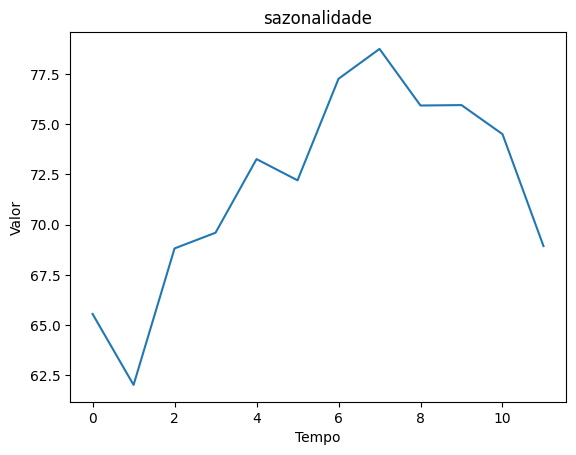

,sazonalidade
sazonalidade,
0,65.550929
1,62.017857
2,68.814071
3,69.596214
4,73.261286
5,72.204714
6,77.259143
7,78.746714
8,75.929286


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,sazonalidade,Mato Grosso Do Sul - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.741626,53.166560,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,65.550929,33.744
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.741710,53.245714,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,62.017857,32.230
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.741794,52.994640,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,68.814071,33.559
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.741878,53.019283,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,69.596214,34.283
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.741962,53.539593,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,73.261286,36.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.097125,NaN,0.523445,NaN,NaN,NaN,NaN,78.746714,103.854
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.657488,NaN,0.521590,NaN,NaN,NaN,NaN,75.929286,95.890
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.966263,NaN,0.518616,NaN,NaN,NaN,NaN,75.950071,89.679
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.205635,NaN,0.515040,NaN,NaN,NaN,NaN,74.504286,99.356


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 240, dtype: float64

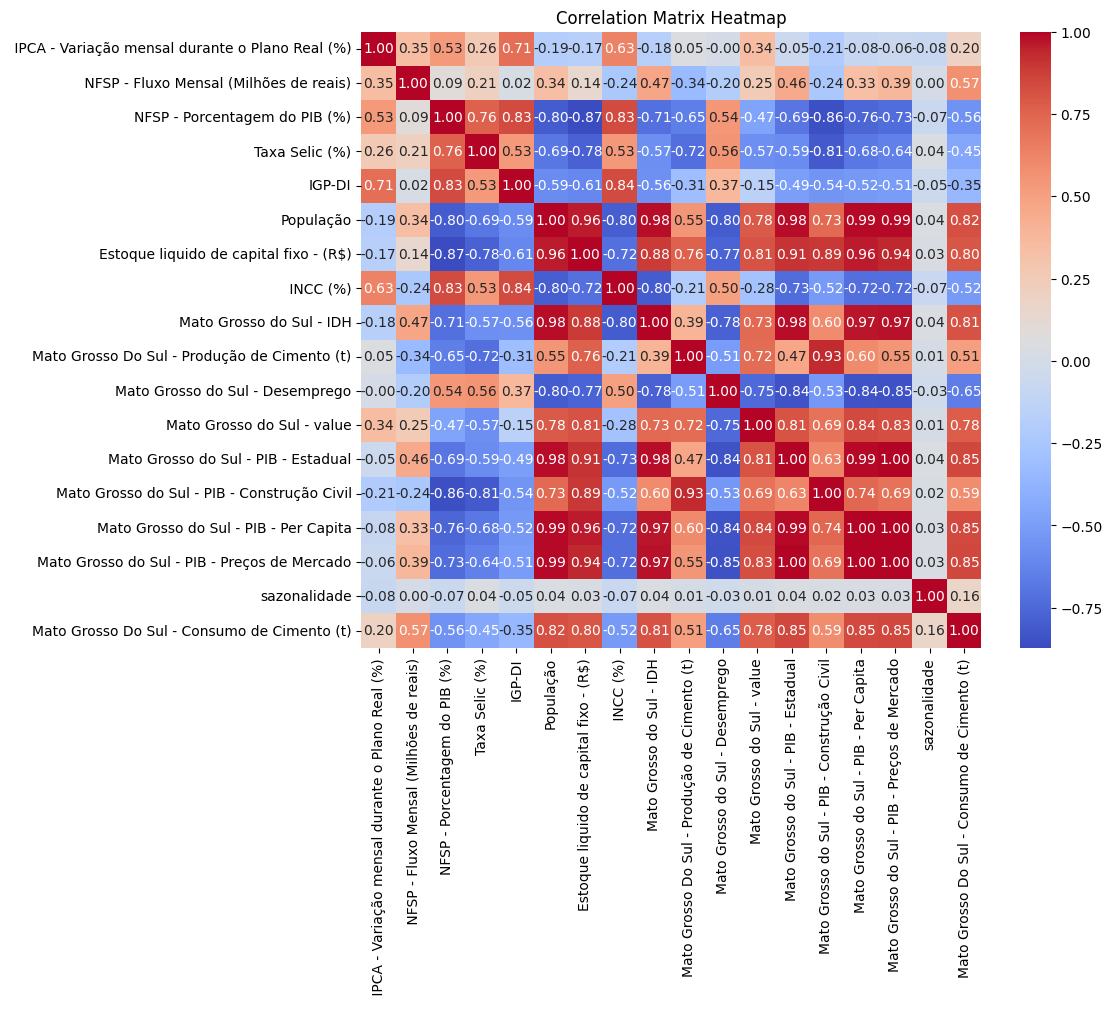

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),1.242264e+03
1,NFSP - Fluxo Mensal (Milhões de reais),2.688196e+02
2,NFSP - Porcentagem do PIB (%),2.685139e+02
3,Taxa Selic (%),5.692596e+01
4,IGP-DI,3.154265e+02
5,População,3.678520e+06
6,Estoque liquido de capital fixo - (R$),5.451562e+06
7,INCC (%),1.247989e+03
8,Mato Grosso do Sul - IDH,1.065516e+07
9,Mato Grosso Do Sul - Produção de Cimento (t),3.295615e+04


In [40]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 4


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,0.969649,0.741626,53.166560,8.248824,0.282837,4.562945e+07,65.550929
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,0.950783,0.741710,53.245714,8.242935,0.284487,4.568706e+07,62.017857
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,0.938332,0.741794,52.994640,8.237046,0.285379,4.574467e+07,68.814071
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,0.926401,0.741878,53.019283,8.231157,0.286089,4.580228e+07,69.596214
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,0.951683,0.741962,53.539593,8.225268,0.286122,4.585990e+07,73.261286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,0.378150,0.755636,57.090845,6.953989,0.311653,5.673072e+07,78.746714
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,0.377666,0.755591,56.907334,6.945585,0.311775,5.672868e+07,75.929286
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,0.377838,0.755545,56.749771,6.937182,0.311905,5.672665e+07,75.950071
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,0.370057,0.755499,56.951568,6.928778,0.312127,5.672461e+07,74.504286


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual
0,0.604311,4.268118,2.039314,3.921218,-2.016914,3.214079,-1.692819,-1.478264,1.157071,-0.425321,-1.585377
1,0.609431,4.096014,1.195209,3.582946,-1.988421,3.051841,-1.673444,-1.469741,1.146571,-0.389043,-1.570153
2,0.562720,3.903698,2.960381,3.422548,-1.959928,2.944772,-1.654069,-1.496777,1.136070,-0.369434,-1.554929
3,0.455907,3.693727,1.040752,3.167136,-1.931435,2.842174,-1.634694,-1.494124,1.125570,-0.353836,-1.539705
4,0.498418,3.454992,2.351150,2.986591,-1.902941,3.059587,-1.615320,-1.438095,1.115069,-0.353108,-1.524481
...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,-1.872446,1.529670,-1.055682,-1.151702,0.208020,1.348192
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,-1.876611,1.519140,-1.075443,-1.166686,0.210697,1.347655
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,-1.875135,1.508610,-1.092410,-1.181670,0.213544,1.347117
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,-1.942040,1.498081,-1.070680,-1.196654,0.218421,1.346579


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual
0,0.604311,4.268118,2.039314,3.921218,-2.016914,3.214079,-1.692819,-1.478264,1.157071,-0.425321,-1.585377
1,0.609431,4.096014,1.195209,3.582946,-1.988421,3.051841,-1.673444,-1.469741,1.146571,-0.389043,-1.570153
2,0.562720,3.903698,2.960381,3.422548,-1.959928,2.944772,-1.654069,-1.496777,1.136070,-0.369434,-1.554929
3,0.455907,3.693727,1.040752,3.167136,-1.931435,2.842174,-1.634694,-1.494124,1.125570,-0.353836,-1.539705
4,0.498418,3.454992,2.351150,2.986591,-1.902941,3.059587,-1.615320,-1.438095,1.115069,-0.353108,-1.524481
...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,-1.491033,1.619694,-0.642098,-0.808997,0.372463,1.332398
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,-1.525186,1.616430,-0.693027,-0.856561,0.341829,1.336310
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,-1.546744,1.613167,-0.757685,-0.904124,0.316474,1.340222
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,-1.586381,1.609904,-0.805380,-0.951687,0.295600,1.344134


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
163    87.863
164    69.723
165    72.765
166    77.937
167    64.332
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 11)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,-0.066954,0.729546,0.933936,-0.931772,1.306283,1.006755
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,-0.130652,0.740978,0.931654,-0.890133,1.308629,1.020757
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,-0.079602,0.752410,0.894757,-0.848494,1.309562,1.034759
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,-0.034473,0.763843,0.857122,-0.806856,1.313523,1.048761
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,-0.177535,0.775275,0.819143,-0.765217,1.313398,1.062764
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,-0.208868,0.786707,0.780583,-0.723579,1.312874,1.076766
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,-0.245300,0.798139,0.741873,-0.681940,1.304768,1.090768
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,-0.333490,0.809571,0.702201,-0.640302,1.293312,1.104770
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,-0.296846,0.821004,0.662172,-0.598663,1.276554,1.118773
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,-0.292462,0.832436,0.622061,-0.557024,1.255749,1.132775


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 11)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[1316593108, 2160605526, 1902508911, 963561773, 3036460339, 2506755749, 2209277414, 1222190301, 378964085, 13208896]


Step: 0 ___________________________________________
val_loss: 95.23993682861328
winner_seed: 1316593108


Step: 1 ___________________________________________
val_loss: 83.93403625488281
winner_seed: 2160605526


Step: 2 ___________________________________________
val_loss: 86.3835220336914


Step: 3 ___________________________________________
val_loss: 90.69508361816406


Step: 4 ___________________________________________
val_loss: 89.77765655517578


Step: 5 ___________________________________________
val_loss: 90.0084228515625


Step: 6 ___________________________________________
val_loss: 102.94600677490234


Step: 7 ___________________________________________
val_loss: 235.59751892089844


Step: 8 ___________________________________________
val_loss: 86.35265350341797


Step: 9 ___________________________________________
val_loss: 102.81135559082031
1/1 [=========

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,70.829872,70.857368,72.520363,76.352028,83.651871,96.4245,105.562828,111.014,117.083,119.894196,119.364738,113.660934
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,6.218124,5.197365,7.075363,1.742973,2.65387,27.009499,18.216827,28.125999,37.795998,38.039192,41.869736,57.048935


0.30038871133232764

[2603947799, 1586282129, 2703763230, 1765409688, 3383520616, 344902713, 2826038560, 2705324628, 2982639300, 3581757189]


Step: 0 ___________________________________________
val_loss: 85.70757293701172
winner_seed: 2603947799


Step: 1 ___________________________________________
val_loss: 74.86848449707031
winner_seed: 1586282129


Step: 2 ___________________________________________
val_loss: 286.4994201660156


Step: 3 ___________________________________________
val_loss: 80.84127044677734


Step: 4 ___________________________________________
val_loss: 74.68238830566406
winner_seed: 3383520616


Step: 5 ___________________________________________
val_loss: 88.48597717285156


Step: 6 ___________________________________________
val_loss: 79.63311767578125


Step: 7 ___________________________________________
val_loss: 89.6298828125


Step: 8 ___________________________________________
val_loss: 71.76658630371094
winner_seed: 2982639300


Step: 9 ________________________________________

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,71.551712,72.023003,72.632401,73.438774,74.535515,75.645378,76.049683,76.940178,78.726463,80.958046,82.993904,83.366287
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,5.496284,6.362999,7.187401,4.656227,6.462486,6.230377,11.296318,5.947823,0.560539,0.896957,5.498901,26.754288


0.09682556354228267

[1238916416, 1640916157, 90092430, 1868128884, 3277167671, 3929913933, 4253965224, 1130215341, 2193075429, 4004809476]


Step: 0 ___________________________________________
val_loss: 94.30396270751953
winner_seed: 1238916416


Step: 1 ___________________________________________
val_loss: 86.07624816894531
winner_seed: 1640916157


Step: 2 ___________________________________________
val_loss: 96.06453704833984


Step: 3 ___________________________________________
val_loss: 77.5860366821289
winner_seed: 1868128884


Step: 4 ___________________________________________
val_loss: 71.6696548461914
winner_seed: 3277167671


Step: 5 ___________________________________________
val_loss: 81.40155029296875


Step: 6 ___________________________________________
val_loss: 86.16265869140625


Step: 7 ___________________________________________
val_loss: 73.66043853759766


Step: 8 ___________________________________________
val_loss: 74.33192443847656


Step: 9 _______________________________________

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,74.490059,74.490936,74.652199,74.83477,75.068253,75.303429,75.387062,75.52919,76.260712,77.128983,77.833366,77.258224
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,2.557938,8.830933,9.207199,3.260231,5.929749,5.888428,11.958939,7.35881,3.026291,4.726021,0.338364,20.646225


0.09281126302365682

[1800296989, 1634010194, 3757672571, 4029954010, 3086266094, 276826983, 3409416592, 3507248537, 2694862000, 3499604167]


Step: 0 ___________________________________________
val_loss: 77.1095962524414
winner_seed: 1800296989


Step: 1 ___________________________________________
val_loss: 70.34672546386719
winner_seed: 1634010194


Step: 2 ___________________________________________
val_loss: 71.98619079589844


Step: 3 ___________________________________________
val_loss: 43.822898864746094
winner_seed: 4029954010


Step: 4 ___________________________________________
val_loss: 83.64344787597656


Step: 5 ___________________________________________
val_loss: 77.97271728515625


Step: 6 ___________________________________________
val_loss: 95.44499969482422


Step: 7 ___________________________________________
val_loss: 92.0500259399414


Step: 8 ___________________________________________
val_loss: 78.40070343017578


Step: 9 ___________________________________________
val_loss: 79.1141

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,69.05217,66.556267,68.902687,74.101257,75.065727,73.761353,71.475548,72.011276,71.080231,70.461945,69.961868,70.385529
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,7.995827,0.896263,3.457687,3.993744,5.932274,4.346352,15.870453,10.876724,8.206772,11.393059,7.533134,13.773529


0.10450195973563545

[1628412632, 4095728354, 3266789055, 659663107, 3671885962, 674437358, 3129268288, 3721108367, 2371232728, 166477988]


Step: 0 ___________________________________________
val_loss: 91.1275634765625
winner_seed: 1628412632


Step: 1 ___________________________________________
val_loss: 106.31168365478516


Step: 2 ___________________________________________
val_loss: 74.92742919921875
winner_seed: 3266789055


Step: 3 ___________________________________________
val_loss: 86.00601959228516


Step: 4 ___________________________________________
val_loss: 88.3425064086914


Step: 5 ___________________________________________
val_loss: 101.33953094482422


Step: 6 ___________________________________________
val_loss: 77.34407806396484


Step: 7 ___________________________________________
val_loss: 79.71501159667969


Step: 8 ___________________________________________
val_loss: 78.7529067993164


Step: 9 ___________________________________________
val_loss: 91.43534088134766
1/1 [==========

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,72.575531,76.545044,82.507843,88.28582,91.728485,90.941727,93.202469,92.992996,89.627182,90.96627,87.859055,85.919823
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,4.472466,10.88504,17.062843,10.190819,10.730484,21.526726,5.856468,10.104996,10.340179,9.111267,10.364052,29.307823


0.16621865171444403

[377798245, 3005636468, 527551394, 2485610904, 3174236792, 2038041222, 411250831, 4142069302, 1149106230, 813924400]


Step: 0 ___________________________________________
val_loss: 96.98039245605469
winner_seed: 377798245


Step: 1 ___________________________________________
val_loss: 60.98116683959961
winner_seed: 3005636468


Step: 2 ___________________________________________
val_loss: 78.72352600097656


Step: 3 ___________________________________________
val_loss: 92.13871002197266


Step: 4 ___________________________________________
val_loss: 87.71917724609375


Step: 5 ___________________________________________
val_loss: 137.7162628173828


Step: 6 ___________________________________________
val_loss: 80.11946105957031


Step: 7 ___________________________________________
val_loss: 167.4232177734375


Step: 8 ___________________________________________
val_loss: 78.3953857421875


Step: 9 ___________________________________________
val_loss: 111.10579681396484
1/1 [===========

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,68.592308,70.511017,75.054688,79.879578,85.119942,89.999382,91.183617,93.303909,95.194534,95.996368,95.886246,94.657707
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,8.455688,4.851013,9.609688,1.784576,4.121941,20.584381,3.837616,10.415909,15.907532,14.141365,18.391243,38.045708


0.1664331497859197

[973805465, 464130413, 613372493, 2893159663, 92957643, 3496140232, 3880011429, 3112289647, 2552506853, 2448857783]


Step: 0 ___________________________________________
val_loss: 90.42154693603516
winner_seed: 973805465


Step: 1 ___________________________________________
val_loss: 105.54265594482422


Step: 2 ___________________________________________
val_loss: 84.19830322265625
winner_seed: 613372493


Step: 3 ___________________________________________
val_loss: 71.05364990234375
winner_seed: 2893159663


Step: 4 ___________________________________________
val_loss: 116.61643981933594


Step: 5 ___________________________________________
val_loss: 84.43647003173828


Step: 6 ___________________________________________
val_loss: 84.81188201904297


Step: 7 ___________________________________________
val_loss: 72.79624938964844


Step: 8 ___________________________________________
val_loss: 94.43962860107422


Step: 9 ___________________________________________
val_loss: 94.1100463

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,72.137474,72.641525,72.029572,71.903831,71.999023,72.245979,72.689728,73.410332,74.566032,76.84729,79.699112,83.51152
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,4.910522,6.981522,6.584572,6.19117,8.998978,2.830978,14.656273,9.477669,4.72097,5.007713,2.204109,26.899521


0.11025290940460092

[1639299606, 58700619, 2206482939, 2682150441, 1083583729, 3396216940, 2150654924, 3342867890, 1422478834, 610295898]


Step: 0 ___________________________________________
val_loss: 78.48506927490234
winner_seed: 1639299606


Step: 1 ___________________________________________
val_loss: 76.71905517578125
winner_seed: 58700619


Step: 2 ___________________________________________
val_loss: 105.03182220458984


Step: 3 ___________________________________________
val_loss: 83.56192779541016


Step: 4 ___________________________________________
val_loss: 46299009024.0


Step: 5 ___________________________________________
val_loss: 94.51998138427734


Step: 6 ___________________________________________
val_loss: 100.96775817871094


Step: 7 ___________________________________________
val_loss: 84.08257293701172


Step: 8 ___________________________________________
val_loss: 75.2822265625
winner_seed: 1422478834


Step: 9 ___________________________________________
val_loss: 99.5836868286132

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,70.121185,69.788437,72.029106,77.615494,87.088814,98.021118,100.973785,100.030197,101.613708,101.260201,99.531143,96.804146
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,6.926811,4.128433,6.584106,0.479507,6.090813,28.606117,13.627785,17.142197,22.326706,19.405197,22.03614,40.192146


0.20788916123441073

[1684037550, 1088058799, 506698608, 523922913, 2644368901, 1057362349, 3212946858, 3105763632, 2752905616, 2616326499]


Step: 0 ___________________________________________
val_loss: 127.65965270996094
winner_seed: 1684037550


Step: 1 ___________________________________________
val_loss: 84.9845962524414
winner_seed: 1088058799


Step: 2 ___________________________________________
val_loss: 81.8109130859375
winner_seed: 506698608


Step: 3 ___________________________________________
val_loss: 114.3321762084961


Step: 4 ___________________________________________
val_loss: 97.4626693725586


Step: 5 ___________________________________________
val_loss: 72.82841491699219
winner_seed: 1057362349


Step: 6 ___________________________________________
val_loss: 93.18338775634766


Step: 7 ___________________________________________
val_loss: 73.17093658447266


Step: 8 ___________________________________________
val_loss: 112.89265441894531


Step: 9 _______________________________________

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,74.958977,78.331558,80.275597,81.318634,82.765747,84.64856,83.940857,83.969406,84.265572,82.735092,79.903816,82.466522
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,2.08902,12.671555,14.830597,3.223633,1.767746,15.233559,3.405144,1.081406,4.978569,0.880089,2.408813,25.854523


0.09801611727131075

[692986649, 904240301, 3772669261, 3327240757, 3021901387, 2140139449, 383618803, 4017891097, 616995144, 3708657820]


Step: 0 ___________________________________________
val_loss: 90.50232696533203
winner_seed: 692986649


Step: 1 ___________________________________________
val_loss: 78.53226470947266
winner_seed: 904240301


Step: 2 ___________________________________________
val_loss: 56.436275482177734
winner_seed: 3772669261


Step: 3 ___________________________________________
val_loss: 56.98485565185547


Step: 4 ___________________________________________
val_loss: 58.43927001953125


Step: 5 ___________________________________________
val_loss: 76.99263000488281


Step: 6 ___________________________________________
val_loss: 104.17288970947266


Step: 7 ___________________________________________
val_loss: 81.26619720458984


Step: 8 ___________________________________________
val_loss: 85.02481842041016


Step: 9 ___________________________________________
val_loss: 79.823509

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,71.858879,71.420059,72.651993,80.233505,94.075897,102.961227,98.748596,95.925293,97.100143,95.971657,94.855759,94.063431
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,5.189117,5.760056,7.206993,2.138504,13.077896,33.546227,11.402596,13.037292,17.813141,14.116653,17.360756,37.451431


0.19741932376288934

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,71.616821,72.316521,74.325638,77.796371,82.109924,85.99527,86.92141,87.51268,88.551758,89.222,88.788895,88.209419
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,5.431179,6.656521,8.880638,0.298629,1.111924,16.58027,0.42459,4.62468,9.264758,7.367,11.293895,31.597419


In [53]:
display(mae)
display(mape)

82.780556

0.12794653675694717